# Plotting Hyperparameter Surfaces
This tutorial takes part of the ['plotting hyperparameter surfaces'](https://openml.github.io/openml-python/master/examples/30_extended/plot_svm_hyperparameters_tutorial.html#sphx-glr-examples-30-extended-plot-svm-hyperparameters-tutorial-py) and ['Peronne et al.'](https://openml.github.io/openml-python/master/examples/40_paper/2018_neurips_perrone_example.html#sphx-glr-examples-40-paper-2018-neurips-perrone-example-py) examples, but has  modifications for the purpose of the tutorial.

In this tutorial we will cover how to visualize the effect of tuning hyperparameters for a certain algorithm on a certain task. This will result in the image below:

<img src="https://raw.githubusercontent.com/PGijsbers/Talks/master/odsc/2019/images/openml/svc_scatterheat.png" style='width: 48%;'/>

In [1]:
%matplotlib notebook
import openml
import numpy as np

## Obtaining the data

First, we need to choose an SVM flow, for example 8353, and a task (here 10-fold CV on 'letter').
Finding the IDs of them are not part of this tutorial, this could for example be done via the website.
For this we use the function ``list_evaluations_setup`` which can automatically join
evaluations conducted by the server with the hyperparameter settings extracted from the
uploaded runs (called *setup*).

In [2]:
df = openml.evaluations.list_evaluations_setups(
    function='predictive_accuracy',
    flows=[8353],  # A SVM flow
    tasks=[6],  # the letter task
    output_format='dataframe',
    # Using this flag incorporates the hyperparameters into the returned dataframe. Otherwise,
    # the dataframe would contain a field ``paramaters`` containing an unparsed dictionary.
    parameters_in_separate_columns=True,
)
df[['run_id', 'setup_id', 'flow_name', 'value', 'sklearn.svm.classes.SVC(16)_C', 'sklearn.svm.classes.SVC(16)_gamma']].head()

,run_id,setup_id,flow_name,value,sklearn.svm.classes.SVC(16)_C,sklearn.svm.classes.SVC(16)_gamma
0,9154533,7087003,sklearn.pipeline.Pipeline(imputation=hyperimp....,0.96700,6085.591208522886,0.026847811757887186
1,9154536,7087006,sklearn.pipeline.Pipeline(imputation=hyperimp....,0.97250,505.7034560908835,0.06955402093038662
2,9154539,7087009,sklearn.pipeline.Pipeline(imputation=hyperimp....,0.94280,87.7420380011505,0.006213629210427689
3,9154544,7087014,sklearn.pipeline.Pipeline(imputation=hyperimp....,0.90415,10.339995195642604,0.006562397636276156
4,9154546,7087016,sklearn.pipeline.Pipeline(imputation=hyperimp....,0.90915,3.7580201465928083,0.011932600722980257


The full dataframe has 46 columns, including all hyperparameter values for each step of the pipeline. Let's look at the SVC hyperparamters in particular:

In [3]:
df.columns[df.columns.str.startswith('sklearn.svm')]

Index(['sklearn.svm.classes.SVC(16)_C',
       'sklearn.svm.classes.SVC(16)_cache_size',
       'sklearn.svm.classes.SVC(16)_class_weight',
       'sklearn.svm.classes.SVC(16)_coef0',
       'sklearn.svm.classes.SVC(16)_decision_function_shape',
       'sklearn.svm.classes.SVC(16)_degree',
       'sklearn.svm.classes.SVC(16)_gamma',
       'sklearn.svm.classes.SVC(16)_kernel',
       'sklearn.svm.classes.SVC(16)_max_iter',
       'sklearn.svm.classes.SVC(16)_probability',
       'sklearn.svm.classes.SVC(16)_random_state',
       'sklearn.svm.classes.SVC(16)_shrinking',
       'sklearn.svm.classes.SVC(16)_tol',
       'sklearn.svm.classes.SVC(16)_verbose'],
      dtype='object')

Values for ``C`` and ``gamma`` can differ orders of magnitude, so we scale them logarithmically for a clearer figure:

In [4]:
hyperparameters = ['sklearn.svm.classes.SVC(16)_C', 'sklearn.svm.classes.SVC(16)_gamma']
df[['C (log)', 'gamma (log)']] = df[hyperparameters].astype(float).apply(np.log10)

## Plotting the response surface

<IPython.core.display.Javascript object>


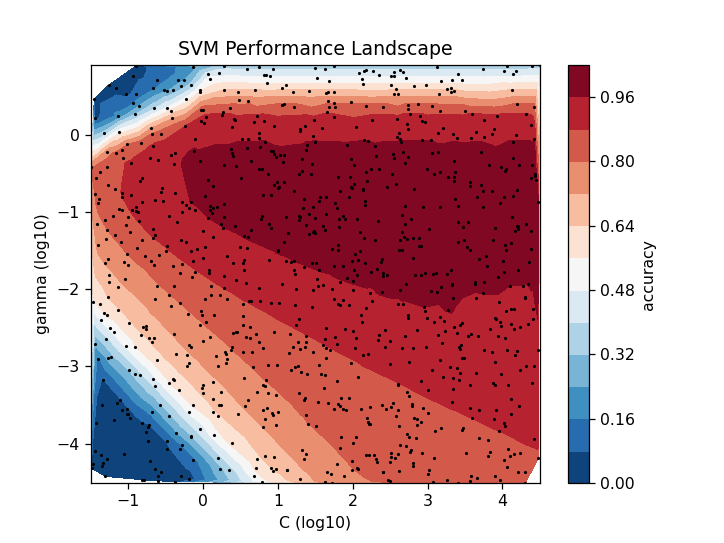

[(-1.5047795904917394, 4.499264829872581),
 (-4.511419140313103, 0.902350207331397),
 Text(0.5, 0, 'C (log10)'),
 Text(0, 0.5, 'gamma (log10)'),
 Text(0.5, 1.0, 'SVM Performance Landscape')]

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

C = df['C (log)']
gamma = df['gamma (log)']
score = df['value']

# Plotting all evaluations:
ax.plot(C, gamma, 'ko', ms=1)  # 'ko' specifies the format: black (k) circles (o)

# Create a contour plot
cntr = ax.tricontourf(C, gamma, score, levels=12, cmap="RdBu_r")

# Adjusting the colorbar
fig.colorbar(cntr, ax=ax, label="accuracy")

# Adjusting the axis limits
ax.set(
    xlim=(min(C), max(C)),
    ylim=(min(gamma), max(gamma)),
    xlabel="C (log10)",
    ylabel="gamma (log10)",
    title='SVM Performance Landscape'
)

## Modeling the response surface

From the surface plot above, one can get an impression of the predictive accuracy for any given hyperparameter values of `C` and `gamma`. In this next section, we model this relationship explicitly using a random forest. The model takes a hyperparameter configuration as input, and produces a prediction of the accuracy as output. This allows us to get quick estimates for what would otherwise require e.g. a 10-fold cross-validation experiment.

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [7]:
hyperparameters = ['sklearn.svm.classes.SVC(16)_C', 'sklearn.svm.classes.SVC(16)_gamma']
x, y = df.loc[:, hyperparameters], df.loc[:, 'value']

In [8]:
forest = RandomForestRegressor(n_estimators=50)
forest.fit(x, y)

RandomForestRegressor(n_estimators=50)

With a surrogate model, we can explore the space much more efficiently to determine new hyperparameter configurations to try. We could also simulate exploring the hyperparameter configuration space with random search:

<IPython.core.display.Javascript object>


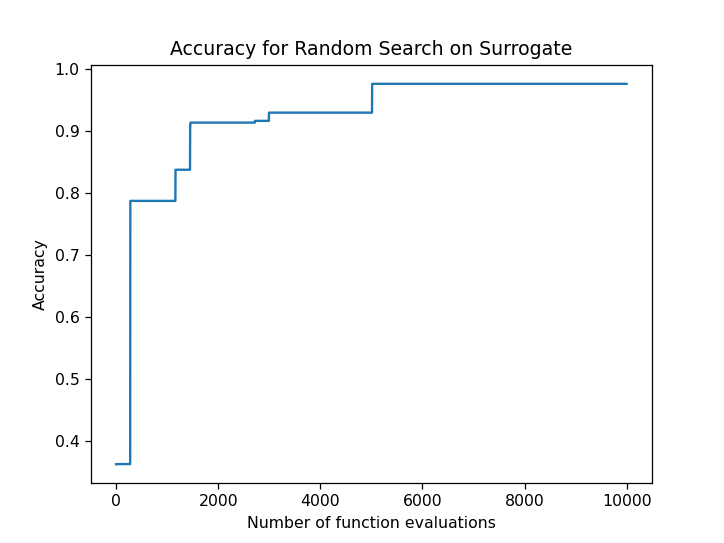

[Text(0.5, 0, 'Number of function evaluations'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Accuracy for Random Search on Surrogate')]

In [15]:
# First we sample 10000 random hyperparameter configurations.
num_samples = 10000
ranges = [(0.000986, 998.492437),  # C
          (0.000988, 913.373845),  # gamma
         ]
X = pd.DataFrame(np.nan, index=range(num_samples), columns=hyperparameters)
for i, range_ in enumerate(ranges):
    col_val = np.random.uniform(low=range_[0], high=range_[1], size=num_samples)
    X.iloc[:, i] = col_val

# Now we can predict the accuracy for each of the 10000 different hyperparameter configurations:
preds = forest.predict(X)

# To simulate navigating the space randomly, we look at the accuracies as if
# we tried the configurations one by one, keeping track of the best result so far:
best_so_far_acc = np.maximum.accumulate(preds)

# Finally we plot our best accuracy as function of the number of evaluations
fig, ax = plt.subplots()
ax.plot(best_so_far_acc)
ax.set(
    xlabel='Number of function evaluations',
    ylabel='Accuracy',
    title='Accuracy for Random Search on Surrogate'
)

From here, we could start building models which also take into account dataset characteristics. We can create a model which takes into account both dataset 'meta-features' and hyperparameter configuration, so that the model may generalize across datasets to new and unseen ones! Unfortunately, we have to leave this as an exercise to the reader :)

---
Code in this notebook is in large part taken from openml-python under the BSD-3-Clause license, see `Talks\odsc\2021\LICENSE`.